In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.seasonal import seasonal_decompose                       
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn.model_selection import train_test_split
import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense,Activation,Dropout
from sklearn import preprocessing
from keras.wrappers.scikit_learn import KerasRegressor
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
#df = pd.read_csv('/content/Scaled_days.csv')

Using TensorFlow backend.


In [0]:
# load the dataset
dataframe = pandas.read_csv('/content/M&M.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [0]:
sales = pd.read_csv("/content/M&M.csv").fillna(0)

In [0]:
# fix random seed for reproducibility
numpy.random.seed(7)

In [0]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [6]:
# split into train and test sets
train_size = int(len(dataset) * 0.80)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
print(len(train), len(test))

1978 495


In [0]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [0]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

In [0]:
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [12]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='Adadelta')
model.fit(trainX, trainY, epochs=10, batch_size=1, verbose=2)

Epoch 1/10
 - 5s - loss: 0.0128
Epoch 2/10
 - 4s - loss: 1.9707e-04
Epoch 3/10
 - 4s - loss: 1.9037e-04
Epoch 4/10
 - 4s - loss: 1.9328e-04
Epoch 5/10
 - 4s - loss: 1.8884e-04
Epoch 6/10
 - 4s - loss: 1.8373e-04
Epoch 7/10
 - 4s - loss: 1.8111e-04
Epoch 8/10
 - 4s - loss: 1.8079e-04
Epoch 9/10
 - 4s - loss: 1.7874e-04
Epoch 10/10
 - 4s - loss: 1.7686e-04


In [0]:
from sklearn.metrics import mean_absolute_error   #MAE
from sklearn.metrics import mean_squared_error as mse   #MSE

def parser(x):
    return datetime.strptime(x,'%Y-%m')

def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())  #RMSE

def RMSLE(predict, target):                   #Root Mean Squared Logarithmic Error
    total = 0 
    for k in range(len(predict)):
        LPred= np.log1p(predict[k]+1)
        LTarg = np.log1p(target[k] + 1)
        if not (math.isnan(LPred)) and  not (math.isnan(LTarg)): 
            total = total + ((LPred-LTarg) **2)
        
    total = total / len(predict)        
    return np.sqrt(total)

def mean_absolute_percentage_error(y_true, y_pred): #MAPE
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))

def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))  #Symmetric Mean Absolute Percentage Error (SMAPE)

In [14]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))



Train Score: 11.96 RMSE
Test Score: 16.28 RMSE


In [15]:
error = mean_squared_error(testY[0], testPredict[:,0])
print('Test MSE: %.3f' % error)

error = mean_absolute_error(testY[0], testPredict[:,0])
print('Test MAE: %.3f' % error)

error = rmse(testY[0], testPredict[:,0])
print('Test RMSE: %.3f' % error)

error = RMSLE(testY[0], testPredict[:,0])
print('Test RMSLE: %.3f' % error)

error = mean_absolute_percentage_error(testY[0], testPredict[:,0])
print('Test MAPE: %.3f' % error)

error2 = smape_kun(testY[0], testPredict[:,0])
print('Test SMAPE: %.3f' % error2)

Test MSE: 265.064
Test MAE: 12.620
Test RMSE: 16.281
Test RMSLE: 0.024
Test MAPE: 0.019
Test SMAPE: 1.829


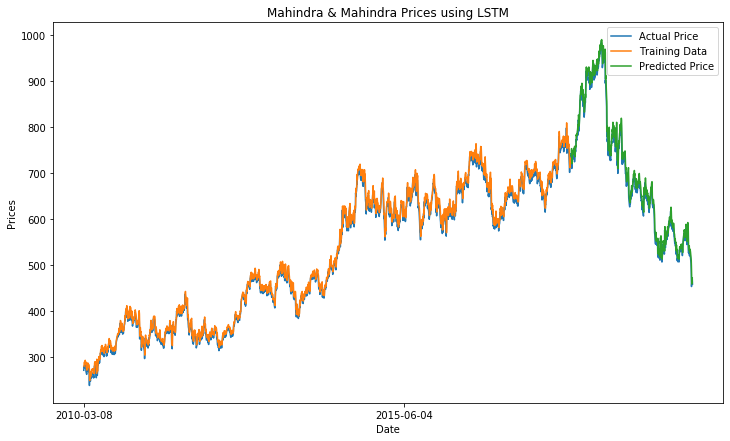

In [16]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.figure(figsize=(12,7))
plt.plot(scaler.inverse_transform(dataset), label='Actual Price')
plt.plot(trainPredictPlot, label='Training Data')
plt.plot(testPredictPlot, label='Predicted Price')
plt.title('Mahindra & Mahindra Prices using LSTM')
plt.xlabel('Date')
plt.ylabel('Prices')
plt.xticks(np.arange(0,2473, 1300), sales['Date'][0:2473:1300])
plt.legend()

In [17]:
error = mean_squared_error(trainY[0], trainPredict[:,0])
print('Train MSE: %.3f' % error)

error = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train MAE: %.3f' % error)

error = rmse(trainY[0], trainPredict[:,0])
print('Train RMSE: %.3f' % error)

error = RMSLE(trainY[0], trainPredict[:,0])
print('Train RMSLE: %.3f' % error)

error = mean_absolute_percentage_error(trainY[0], trainPredict[:,0])
print('Train MAPE: %.3f' % error)

error2 = smape_kun(trainY[0], trainPredict[:,0])
print('Train SMAPE: %.3f' % error2)

Train MSE: 143.053
Train MAE: 9.606
Train RMSE: 11.960
Train RMSLE: 0.024
Train MAPE: 0.019
Train SMAPE: 1.920
